In [1]:
# CodSoft Project 2
# Credit Card Fraud Detection using Logistic Regression, Random Forest, and XGBoost


In [3]:
# Load the Dataset
import numpy as np
import pandas as pd


In [5]:
train_data_path = "./fraudTrain.csv"
test_data_path = "./fraudTest.csv"


In [7]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [8]:
# Explore the Dataset
print(f"Train Dataset Length: {len(train_df)}, Test Dataset Length: {len(test_df)}")
combined_data = pd.concat([train_df, test_df])
print(f"Combined Dataset Length: {len(combined_data)}")
combined_data.info()

Train Dataset Length: 1296675, Test Dataset Length: 555719
Combined Dataset Length: 1852394
<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merc

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

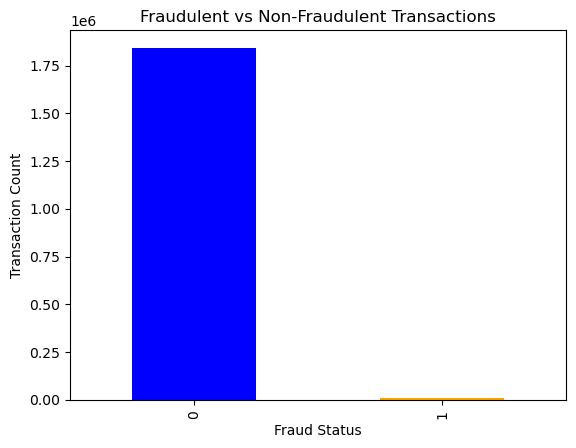

In [13]:
# Visualizing Fraud Distribution
combined_data.groupby('is_fraud')['amt'].count().plot(kind='bar', color=['blue', 'orange'])
plt.title("Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("Fraud Status")
plt.ylabel("Transaction Count")
plt.show()

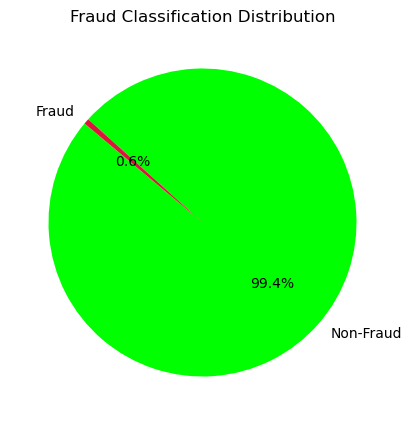

In [17]:
# Pie Chart for Fraud Distribution
fraud_counts = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 5))
plt.pie(fraud_counts, labels=["Non-Fraud", "Fraud"], autopct="%1.1f%%", colors=['lime', 'crimson'], startangle=140)
plt.title("Fraud Classification Distribution")
plt.show()

In [19]:
# Separate Fraudulent and Non-Fraudulent Transactions
fraudulent = combined_data[combined_data['is_fraud'] == 1]
non_fraudulent = combined_data[combined_data['is_fraud'] == 0]
print(f"Fraudulent Transactions: {len(fraudulent)}, Non-Fraudulent Transactions: {len(non_fraudulent)}")

Fraudulent Transactions: 9651, Non-Fraudulent Transactions: 1842743


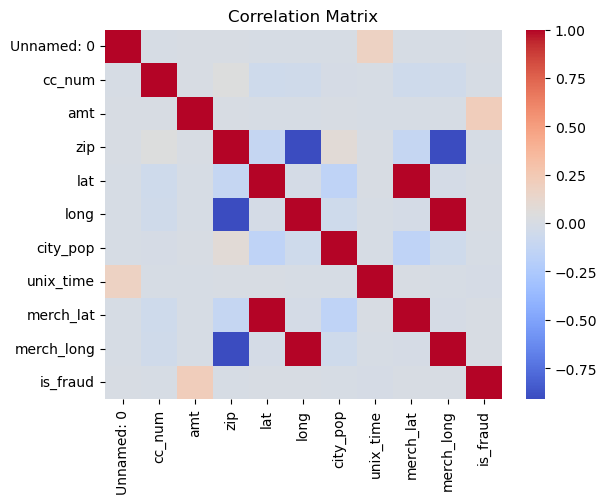

In [21]:
# Correlation Matrix
correlation_matrix = combined_data.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Class Distribution: is_fraud
0    1842743
1       9651
Name: count, dtype: int64
Imbalance Ratio: 0.52%
Balanced Dataset Shape: (19302, 23)


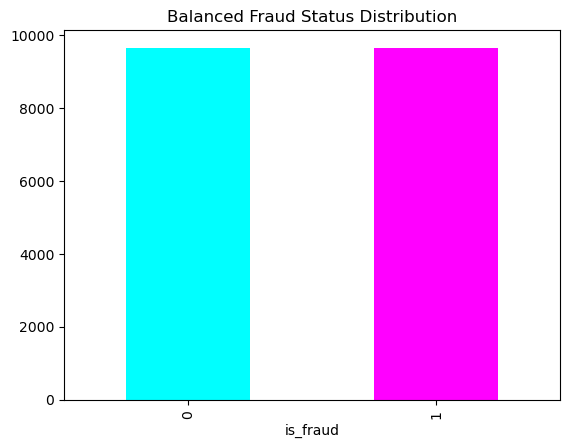

In [23]:
# Handle Class Imbalance
class_counts = combined_data['is_fraud'].value_counts()
print("Class Distribution:", class_counts)
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"Imbalance Ratio: {imbalance_ratio:.2%}")

balanced_data = pd.concat([fraudulent, non_fraudulent.sample(len(fraudulent), random_state=42)])
print(f"Balanced Dataset Shape: {balanced_data.shape}")

balanced_data.groupby('is_fraud')['amt'].count().plot(kind='bar', color=['cyan', 'magenta'])
plt.title("Balanced Fraud Status Distribution")
plt.show()

In [25]:
# Drop Unnecessary Columns
columns_to_remove = ['Unnamed: 0', 'merchant', 'cc_num', 'first', 'last',
                     'gender', 'trans_num', 'unix_time', 'street',
                     'merch_lat', 'merch_long', 'job', 'zip']

balanced_data.drop(columns=columns_to_remove, inplace=True)
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19302 entries, 2449 to 135673
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  19302 non-null  object 
 1   category               19302 non-null  object 
 2   amt                    19302 non-null  float64
 3   city                   19302 non-null  object 
 4   state                  19302 non-null  object 
 5   lat                    19302 non-null  float64
 6   long                   19302 non-null  float64
 7   city_pop               19302 non-null  int64  
 8   dob                    19302 non-null  object 
 9   is_fraud               19302 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 1.6+ MB


In [27]:
# Feature Engineering
balanced_data['trans_date_trans_time'] = pd.to_datetime(balanced_data['trans_date_trans_time'])
balanced_data['dob'] = pd.to_datetime(balanced_data['dob'])

balanced_data['transaction_hour'] = balanced_data['trans_date_trans_time'].dt.hour
def time_of_day(hour):
    if 4 < hour <= 12:
        return 'Morning'
    elif 12 < hour <= 20:
        return 'Afternoon'
    else:
        return 'Night'

balanced_data['transaction_period'] = balanced_data['transaction_hour'].apply(time_of_day)
balanced_data.drop(columns=['trans_date_trans_time'], inplace=True)

balanced_data['age'] = pd.Timestamp.now().year - balanced_data['dob'].dt.year
balanced_data.drop(columns=['dob'], inplace=True)

In [29]:
# Encode Categorical Data
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = balanced_data.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()

balanced_data[categorical_cols] = encoder.fit_transform(balanced_data[categorical_cols])

In [31]:
# Scale Numerical Features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(balanced_data), columns=balanced_data.columns)

print(f"Non-Fraudulent Count: {scaled_data[scaled_data['is_fraud'] == 0].shape[0]}")
print(f"Fraudulent Count: {scaled_data[scaled_data['is_fraud'] == 1].shape[0]}")

Non-Fraudulent Count: 9651
Fraudulent Count: 9651


In [33]:
# Split the Data
from sklearn.model_selection import train_test_split

X = scaled_data.drop(columns=['is_fraud'])
y = scaled_data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
def make_predictions(model, test_set, threshold=0.5):
    probs = model.predict_proba(test_set)[:, 1]
    predictions = (probs >= threshold).astype(int)
    return predictions

logistic_predictions = make_predictions(logistic_model, X_test, threshold=0.4)
print("Logistic Regression Report:\n", classification_report(y_test, logistic_predictions))

Logistic Regression Report:
               precision    recall  f1-score   support

         0.0       0.93      0.72      0.81      1932
         1.0       0.77      0.95      0.85      1929

    accuracy                           0.83      3861
   macro avg       0.85      0.83      0.83      3861
weighted avg       0.85      0.83      0.83      3861



In [39]:
# XGBoost Classifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_train, y_train)
xgb_predictions = make_predictions(xgb_model, X_test, threshold=0.4)
print("XGBoost Report:\n", classification_report(y_test, xgb_predictions))

XGBoost Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1932
         1.0       0.97      0.98      0.97      1929

    accuracy                           0.97      3861
   macro avg       0.97      0.97      0.97      3861
weighted avg       0.97      0.97      0.97      3861



In [41]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = make_predictions(rf_model, X_test, threshold=0.4)
print("Random Forest Report:\n", classification_report(y_test, rf_predictions))

Random Forest Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1932
         1.0       0.96      0.97      0.97      1929

    accuracy                           0.97      3861
   macro avg       0.97      0.97      0.97      3861
weighted avg       0.97      0.97      0.97      3861



In [43]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=5, min_samples_leaf=2)
dt_model.fit(X_train, y_train)
dt_predictions = make_predictions(dt_model, X_test, threshold=0.4)
print("Decision Tree Report:\n", classification_report(y_test, dt_predictions))

Decision Tree Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      1932
         1.0       0.94      0.98      0.96      1929

    accuracy                           0.96      3861
   macro avg       0.96      0.96      0.96      3861
weighted avg       0.96      0.96      0.96      3861

